In [59]:
!pip install yfinance
!pip install seaborn
!pip install textblob
!pip install bs4

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, clone
from joblib import Parallel, delayed
from scipy.optimize import minimize
import datetime

import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# Scrapping data from the *beige book*.

The first step involves scraping textual data from the Beige Book. We are focusing on the National Summary and the New York report. We begin by setting up various functions that will be useful for scraping, including generating combinations (year: from 2014 to 2022, month: from 01 to 12, report region: "su" for summary and "ny" for New York).

In [2]:
def gen(skip=False):
    """
    Generator function that yields tuples representing combinations of year, month, and region.

    Parameters:
    - skip (bool): Optional parameter to skip previously processed entries based on a CSV file.

    Yields:
    tuple: A tuple containing (year, month, region) for each combination.

    """
    
    regions = ("su", "ny")

    for year in range(2014, 2023):
        os.makedirs(f"txt/{year}", exist_ok=True)
        for month in range(1, 13):
            if skip and (year, month) in norelease:
                continue
            os.makedirs(f"txt/{year}/{month:02d}", exist_ok=True)
            for region in regions:
                yield year, month, region

def get_txt_file(t):
    """
    Get the path of the text file based on the input tuple.

    Parameters:
    - t (tuple): A tuple containing (year, month, region).

    Returns:
    str: File path of the corresponding text file.

    """
    return f"txt/{t[0]}/{t[1]:02d}/{t[0]}-{t[1]:02d}-{t[2]}.txt"

Next, we establish the environment to store the Beige Book data.

In [3]:
folder_path = 'out/csv/'

# Check if the folder does not exist, then create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

# Create an empty CSV file named "missing" in the folder
csv_file_path = os.path.join(folder_path, 'missing.csv')
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

print(f"Empty CSV file '{csv_file_path}' created successfully.")

Folder 'out/csv/' created successfully.
Empty CSV file 'out/csv/missing.csv' created successfully.


Next, we proceed to scrape the data.

In [4]:
def scrape(skip=False):
    """
    Scrape text data from a website and save it to local text files.

    Parameters:
    - skip (bool): Optional parameter to skip previously scraped entries.

    """
    # Open CSV file to record missing entries
    errorfile = open("out/csv/missing.csv", "w")
    errorfile.write("year,month,region\n")

    # Iterate over year, month, and region combinations
    for year, month, region in gen(skip):
        print(f"{year}", f"{month:02d}", f"{region}", end=" ")
        header = "https://www.minneapolisfed.org/beige-book-reports/"
        url = header + f"{year}/{year}-{month:02d}-{region}"
        
        try:
            # Get text content from the URL
            txt = get_text(url)
            
            # Save the text to a local file
            with open(get_txt_file((year, month, region)), "w") as f:
                f.write(txt)
            
            print("Available")
        
        except ValueError:
            # Handle cases where the URL is not found (404 error)
            errorfile.write(f"{year},{month:02d},{region}\n")
            print("Not Available")

    # Close the CSV file
    errorfile.close()

def get_text(url):
    """
    Get text content from a given URL.

    Parameters:
    - url (str): The URL to retrieve text content from.

    Returns:
    str: The raw text content.

    """
    # Send a GET request to the URL
    r = requests.get(url)
    
    # Check if the URL is not found (404 error)
    if r.status_code == 404:
        raise ValueError
    
    # Check for other HTTP status codes
    if r.status_code != 200:
        raise RuntimeError(f"Status Code: {r.status_code}")
    
    # Parse HTML content with BeautifulSoup
    soup = BeautifulSoup(r.text, features="html5lib")
    
    # Extract text from specific HTML elements
    div = soup.find("div", class_="col-sm-12 col-lg-8 offset-lg-1")
    raw = re.sub(r"\s*\n\s*", "\n", div.text).strip()
    raw = raw.split("\n", 3)[3]
    
    return raw

The actual scraping process of the data takes approximately 3 minutes. To avoid repeating this step, we have attached a "txt.zip" file to our email. You simply need to decompress it into your workspace, and it contains the Beige Book data directly, which will be useful for the subsequent steps.

In [5]:
scrape()

2014 01 su Available
2014 01 ny Available
2014 02 su Not Available
2014 02 ny Not Available
2014 03 su Available
2014 03 ny Available
2014 04 su Available
2014 04 ny Available
2014 05 su Not Available
2014 05 ny Not Available
2014 06 su Available
2014 06 ny Available
2014 07 su Available
2014 07 ny Available
2014 08 su Not Available
2014 08 ny Not Available
2014 09 su Available
2014 09 ny Available
2014 10 su Available
2014 10 ny Available
2014 11 su Not Available
2014 11 ny Not Available
2014 12 su Available
2014 12 ny Available
2015 01 su Available
2015 01 ny Available
2015 02 su Not Available
2015 02 ny Not Available
2015 03 su Available
2015 03 ny Available
2015 04 su Available
2015 04 ny Available
2015 05 su Not Available
2015 05 ny Not Available
2015 06 su Available
2015 06 ny Available
2015 07 su Available
2015 07 ny Available
2015 08 su Not Available
2015 08 ny Not Available
2015 09 su Available
2015 09 ny Available
2015 10 su Available
2015 10 ny Available
2015 11 su Not Avail

We delete the empty files corresponding to the months where no Beige Book was published.

In [7]:
def delete_empty_folders(root):

    deleted = set()
    
    for current_dir, subdirs, files in os.walk(root, topdown=False):

        still_has_subdirs = False
        for subdir in subdirs:
            if os.path.join(current_dir, subdir) not in deleted:
                still_has_subdirs = True
                break
    
        if not any(files) and not still_has_subdirs:
            os.rmdir(current_dir)
            deleted.add(current_dir)

    return deleted

In [9]:
root = '.\\txt'
delete_empty_folders(root)

{'.\\txt\\2014\\02',
 '.\\txt\\2014\\05',
 '.\\txt\\2014\\08',
 '.\\txt\\2014\\11',
 '.\\txt\\2015\\02',
 '.\\txt\\2015\\05',
 '.\\txt\\2015\\08',
 '.\\txt\\2015\\11',
 '.\\txt\\2016\\02',
 '.\\txt\\2016\\05',
 '.\\txt\\2016\\08',
 '.\\txt\\2016\\12',
 '.\\txt\\2017\\02',
 '.\\txt\\2017\\06',
 '.\\txt\\2017\\08',
 '.\\txt\\2017\\12',
 '.\\txt\\2018\\02',
 '.\\txt\\2018\\06',
 '.\\txt\\2018\\08',
 '.\\txt\\2018\\11',
 '.\\txt\\2019\\02',
 '.\\txt\\2019\\05',
 '.\\txt\\2019\\08',
 '.\\txt\\2019\\12',
 '.\\txt\\2020\\02',
 '.\\txt\\2020\\06',
 '.\\txt\\2020\\08',
 '.\\txt\\2020\\11',
 '.\\txt\\2021\\02',
 '.\\txt\\2021\\05',
 '.\\txt\\2021\\08',
 '.\\txt\\2021\\11',
 '.\\txt\\2022\\02',
 '.\\txt\\2022\\05',
 '.\\txt\\2022\\08',
 '.\\txt\\2022\\12'}

# Creating Sectors and Sentiment Analysis

Next, we proceed to create the list of keywords for the different sectors that we will search for in the Beige Book to build our corpus of sentences.

In [10]:
automobile_related_words = [
    'Automobile', 'Automobiles', 'Auto', 'Autos', 'Car', 'Cars', 'Motor Vehicle', 'Motor Vehicles', 'Vehicle', 'Vehicles',
    'Automotive', 'Auto Manufacturing', 'Car Production', 'Car Industry', 'Auto Sector', 'Car Manufacturing',
    'Motorcar', 'Motorcars', 'Vehicle Manufacturing', 'Auto Sector', 'Auto Production', 'Car Assembly',
    'Auto Manufacturing', 'Car Fabrication', 'Vehicle Assembly', 'Motorcar Industry', 'Auto Fabrication',
    'Automotive Assembly', 'Car Fabrication', 'Motorcar Manufacturing', 'Auto Assembly', 'Auto Fabrication',
    'Car Assembling', 'Motor Vehicle Industry', 'Auto Industry', 'Vehicle Fabrication'
]

real_estate_related_words = [
    'Real Estate', 'Real Estates', 'Property', 'Properties', 'Realty', 'Real Property', 'Real Assets', 'Realty Sector',
    'Real Estate Market', 'Real Assets Sector', 'Real Property Industry', 'Realty Market', 'Land & Property',
    'Real Estate Development', 'Realty Business', 'Property Market', 'Real Estate Sector', 'Land & Assets',
    'Real Estate Business', 'Realty Development', 'Real Property Market', 'Realty Industry', 'Real Estate Investment',
    'Realty Sector', 'Property Business', 'Real Assets Market', 'Real Property Business', 'Realty Investment',
    'Real Estate Business', 'Property Development'
]

tourism_related_words = [
    'Tourism', 'Travel', 'Hospitality', 'Leisure', 'Vacation', 'Tourist', 'Tourists', 'Tourism Business', 'Travel Business',
    'Holiday', 'Tourist Business', 'Vacation Business', 'Leisure Business', 'Hospitality Business', 'Tourism Market',
    'Travel Market', 'Vacation Market', 'Leisure Market', 'Tourist Market', 'Hospitality Market', 'Travel & Tourism',
    'Leisure & Hospitality', 'Tourist & Vacation', 'Holiday Sector', 'Tourism Development', 'Travel Development'
]

banking_related_words = [
    'Financial', 'Banking', 'Financial Services', 'Finance', 'Banking & Investment', 'Finances', 'Banking Services',
    'Financial & Banking', 'Investment', 'Banking & Finance', 'Financial Market', 'Banking', 'Finance & Investment',
    'Financial Business', 'Investments', 'Banking & Economics', 'Finance & Banking', 'Financial & Investment',
    'Banking & Finance Industry', 'Banking & Finance Sector', 'Investment & Finance', 'Financial & Banking Industry',
    'Financial & Investment Industry', 'Banking & Investment Industry', 'Finance & Banking Business',
    'Banking & Investment Business', 'Financial & Banking Services', 'Investment & Banking', 'Finance & Investment Business',
    'Banking & Financial Services'
]

energy_related_words = [
    'Energy', 'Power', 'Fuel', 'Energy Production', 'Renewable Energy', 'Energy & Power', 'Power & Utilities',
    'Fuel', 'Energy Generation', 'Renewable Energy', 'Power Generation', 'Fuel Production', 'Energy Business',
    'Power & Energy', 'Energy Market', 'Fuel & Power', 'Renewable Energy Production', 'Power & Fuel', 'Energy & Utilities',
    'Energy & Fuel', 'Renewable Energy Business', 'Power & Fuel Industry', 'Energy & Power Sector', 'Fuel & Energy',
    'Renewable Energy Market', 'Power & Utilities Industry', 'Energy & Power Industry', 'Fuel & Power Sector',
    'Energy & Fuel Industry', 'Renewable Energy & Power', 'Gas', 'Electricity'
]

In [11]:
def split_text_into_sentences(file_path, sector_words):
    """
    Split text content from a file into sentences and filter those containing specific sector-related words.

    Parameters:
    - file_path (str): Path to the file containing the text content.
    - sector_words (list): List of sector-related words to filter sentences.

    Returns:
    list: List of sentences containing the specified sector-related words.

    """
    # Read content from the file
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Use regular expression to split text into sentences
    sentences = [sentence.strip() for sentence in re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', content) if sentence.strip()]

    # Compile the regular expression pattern outside the loop
    pattern = re.compile(r'\b(?:' + '|'.join(sector_words) + r')\b', flags=re.IGNORECASE)

    # Filter sentences based on the presence of sector-related words
    matching_sentences = [sentence for sentence in sentences if pattern.search(sentence)]

    return matching_sentences

Next, we create the dataframe containing the sentences corresponding to the different sectors for the various years.

In [12]:
base_dir = '.\\txt'  # Replace with your actual base folder path

list_name =[]
# Iterate through each year directory
for year_dir in os.listdir(base_dir):
    year_path = os.path.join(base_dir, year_dir)

    # Iterate through each month directory
    for month_dir in os.listdir(year_path):
        month_path = os.path.join(year_path, month_dir)

        # Iterate through each file in the month directory
        for filename in os.listdir(month_path):
            file_path = os.path.join(month_path, filename)
            list_name.append(file_path)

df = pd.DataFrame(index = list_name, columns=['Automobile', 'Real_Estate', 'Tourism', 'Banking', 'Energy'])

sectors = df.columns.to_list()
L = df['Automobile'].index

for s in range(len(sectors)) :
    for i in range(len(df)):
        df[sectors[s]][i] = split_text_into_sentences(L[i], vars()[sectors[s].lower() + '_related_words'])

df['idx'] = np.nan
df['year'] = np.nan
for i in range(len(df)):
    df['idx'][i] = df.reset_index()['index'][i][-14:]
    df['year'][i] = df.reset_index()['index'][i][-14:-10]

df = df.reset_index(drop=True)

df = df[['idx','year', 'Banking', 'Real_Estate', 'Automobile','Energy', 'Tourism']]

In [13]:
df

,idx,year,Banking,Real_Estate,Automobile,Energy,Tourism
0,2014-01-ny.txt,2014,[A major employment agency reports that hiring...,[Home sales activity picked up in the final mo...,[New auto sales remained fairly robust in Nove...,[],[General merchandise retailers indicate that h...
1,2014-01-su.txt,2014,[According to District reports that mention ba...,[Real estate markets generally continued to im...,"[Richmond, Atlanta, and San Francisco noted st...",[The eight Districts reporting on energy indic...,[Two-thirds of Districts noted increases in hi...
2,2014-03-ny.txt,2014,[Financial Developments\nSmall to medium-sized...,"[Housing markets were mixed, while commercial ...",[New auto sales weakened noticeably in January...,[],[Tourism activity was mixed in January and ear...
3,2014-03-su.txt,2014,[Banking and Financial Services\nDistrict repo...,[Residential real estate markets continued to ...,[Weather was also cited as a contributing fact...,[Districts reported that energy production and...,[Tourism increased in a number of Districts bu...
4,2014-04-ny.txt,2014,"[Moreover, two major New York City employment ...",[Both housing markets and commercial real esta...,[Both general merchandise retailers and auto d...,[],[Tourism activity has been mixed since the las...
...,...,...,...,...,...,...,...
137,2022-09-su.txt,2022,[Loan demand was mixed; while financial instit...,[Despite some reports of strong leasing activi...,[Auto sales remained muted across most Distric...,"[While demand for energy products was robust, ...",[Hospitality and tourism contacts highlighted ...
138,2022-10-ny.txt,2022,[Conditions in the broad finance sector deteri...,[Commercial real estate markets were slightly ...,[Auto dealers in upstate New York reported tha...,[There were also scattered reports of price de...,"[Consumer spending remained flat, while touris..."
139,2022-10-su.txt,2022,"[Banking conditions were steady., Financial co...",[Commercial real estate slowed in both constru...,"[Retail spending was relatively flat, reflecti...","[Energy activity expanded moderately, whereas ...","[Travel and tourist activity rose strongly, bo..."
140,2022-11-ny.txt,2022,[While conditions in the broad finance sector ...,"[Commercial real estate markets stabilized, an...",[Auto dealers in upstate New York reported sca...,[],[Consumer spending was mixed but little change...


In [14]:
df_agg = df.groupby('year')[['Banking', 'Real_Estate', 'Automobile','Energy', 'Tourism']].sum()
df_agg

,Banking,Real_Estate,Automobile,Energy,Tourism
year,,,,,
2014,[A major employment agency reports that hiring...,[Home sales activity picked up in the final mo...,[New auto sales remained fairly robust in Nove...,[The eight Districts reporting on energy indic...,[General merchandise retailers indicate that h...
2015,[Financial Developments\nBankers report increa...,[Construction and Real Estate\nThe District's ...,[Auto dealers characterize sales as sluggish i...,[Overall demand for energy-related products an...,[Retailers report that holiday season sales we...
2016,[Financial Developments\nSmall to medium-sized...,[Residential real estate conditions continued ...,[New vehicle sales in upstate New York were re...,[Several Districts reported the strong dollar'...,"[Consumer spending has been sluggish, with tou..."
2017,[Banking and Finance\nSmall- to medium-sized b...,"[Housing markets have been mixed, with weaknes...",[Auto dealers in upstate New York reported tha...,[Growth in the energy industry was mixed; two ...,[Broadway theaters reported that ticket prices...
2018,[Banking and Finance\nSmall to medium-sized ba...,[Commercial real estate markets were also stea...,[Auto sales in upstate New York were steady to...,"[Among reporting Districts, agricultural condi...",[One large retail chain noted that they hired ...
2019,"[Firms in manufacturing, wholesale trade, fina...",[Housing markets have shown some further signs...,[New vehicle sales were mostly flat in recent ...,[The majority of Districts indicated that manu...,"[On the other hand, tourism has remained fairl..."
2020,"[Finally, banks reported some pickup in loan d...",[Commercial real estate markets have weakened ...,"[Consumer spending was mixed, with retailers g...","[Agricultural conditions were little changed, ...","[Consumer spending was mixed, with retailers g..."
2021,[The only exceptions were manufacturing and fi...,[Real Estate and Construction\nHousing markets...,"[Consumer spending declined, with holiday sale...",[Auto sales weakened somewhat since the previo...,"[Consumer spending declined, with holiday sale..."
2022,[Finance-sector contacts reported ongoing impr...,[The home sales market has been unusually robu...,"[Consumer spending was mixed, with vehicle sal...",[Reports on the energy sector indicated modest...,"[Consumer spending was mixed, with vehicle sal..."


We proceed with sentiment analysis based on the sentences of a specific sector for a given year. We take into account the number of previously retrieved sentences and calculate the polarity score for each sentence using TextBlob. Then, we compute the average polarity score.

In [26]:
def calculate_sentiment_scores(df_agg):
    """
    Calculate sentiment scores for each sector and year based on aggregated sentences.

    Parameters:
    - df_agg : DataFrame
        A DataFrame containing aggregated sentences for each sector and year.

    Global Variable:
    - df_sentiment : DataFrame
        The resulting DataFrame containing sentiment scores for each sector and year. This DataFrame is accessible directly after calling the function.

    Returns:
    None
    """
    global df_sentiment
    df_sentiment = pd.DataFrame(columns=df_agg.columns)

    for index, row in df_agg.iterrows():
        sentiment_scores = {}
        for column, sentences in row.items():
            # Calculate average polarity across sentences
            average_polarity = 0
            for sentence in sentences:
                blob = TextBlob(sentence)
                # Use TextBlob's sentiment analysis
                sentiment = blob.sentiment
                average_polarity += sentiment.polarity
            average_polarity = average_polarity / len(sentences)
            sentiment_scores[column] = average_polarity

        # Add average polarity to the new DataFrame
        df_sentiment.loc[index] = sentiment_scores


In [27]:
calculate_sentiment_scores(df_agg)

# Now 'df_sentiment' contains average polarity scores for each sector.
df_sentiment

,Banking,Real_Estate,Automobile,Energy,Tourism
2014,0.034286,0.095321,0.165006,0.064985,0.068013
2015,0.066297,0.138355,0.154013,0.027471,0.090519
2016,0.035733,0.116638,0.150894,-0.001881,0.071319
2017,-0.017539,0.113468,0.090248,0.040653,0.124688
2018,0.081129,0.097510,0.138533,0.094518,0.142854
2019,0.068315,0.097803,0.087605,-0.039861,0.103999
2020,0.052681,0.110991,0.112079,-0.020250,0.101968
2021,0.062069,0.140916,0.042906,0.072387,0.127005
2022,0.126117,0.102131,0.117985,0.100169,0.121100


Finally, we define the function that will be used as a signal for the Markovitz portfolio.

In [28]:
def score(year):
    return df_sentiment.loc[year].to_list()

# Collecting financial data and pre-processing

In this project we use returns calculated as the spot price for the day minus the previous day's price at market close.

In [29]:
def ret(data):
    """
    Calculate daily returns from adjusted closing data.

    Parameters:
    - data: DataFrame, adjusted closing data for multiple tickers.

    Returns:
    - DataFrame, the calculated daily returns.
    """
    data1 = data.diff().iloc[1:]
    return data1

In [30]:
tick_list=['JPM', 'BAC', 'GS', 'C', 'WFC', 'SPG', 'PLD', 'BX', 'EQR', 'GM', 'F', 'TM', 'STLA', 'XOM', 'CVX', 'COP', 'STLA', 'DUK', 'DIS', 'MAR', 'HLT', 'EXPE', 'DAL']

In [31]:
def extraction_return(start, end, tick_list):
    """
    Download adjusted closing data for a given list of tickers and calculate daily returns.

    Parameters:
    - start: int, start date in YYYY format.
    - end: int, end date in YYYY format.
    - tick_list: list, list of tickers to download.

    Returns:
    - DataFrame, the calculated daily returns.
    """
    # Use yfinance to download adjusted closing prices
    data = yf.download(tick_list, f'{start}-01-01', f'{end}-01-03', interval="1d")['Adj Close']
    data = data.astype(float)

    # Calculate returns using the ret function
    returns = ret(data)

    # Remove rows with NaN values in any column
    Nan = returns.index[returns.isnull().any(axis=1)]
    #returns.drop(Nan, 0, inplace=True)
    returns.dropna(axis=0, inplace=True)

    return returns


We calculate sector prices as an average of the various prices of representative companies in each sector. For example, the US banking sector is represented as a weighted average of the revenues (used here in 2020 to give an order of magnitude) of JP Morgan, Bank of America, Goldman Sachs, Citi and Wells Fargo. Similarly, the other sectors are made up of other representative companies.

In [41]:
def matrix_return(start, end):
    '''Returns the returns of different sectors: Banking, Automobile, Real Estate, Energy, and Tourism as a DataFrame.

    Parameters:
        - start: int, start date in YYYY format.
        - end: int, end date in YYYY format.
    
    Returns:
        - DataFrame, the returns of different sectors as specified.
    '''

    data = extraction_return(start, end, tick_list)

    # Calculate the columns of the return matrix based on specified weights (weighted by revenue)
    data['Banking'] = 0.31 * data['JPM'] + 0.21 * data['BAC'] + 0.11 * data['GS'] + 0.19 * data['C'] + 0.19 * data['WFC']
    data['Real_Estate'] = 0.16 * data['SPG'] + 0.21 * data['PLD'] + 0.54 * data['BX'] + 0.09 * data['EQR']
    data['Automobile'] = 0.16 * data['GM'] + 0.17 * data['F'] + 0.37 * data['TM'] + 0.30 * data['STLA']
    data['Energy'] = 0.57 * data['XOM'] + 0.29 * data['CVX'] + 0.07 * data['COP'] + 0.07 * data['DUK']
    data['Tourism'] = 0.64 * data['DIS'] + 0.10 * data['MAR'] + 0.04 * data['HLT'] + 0.05 * data['EXPE'] + 0.17 * data['DAL']

    # Drop unnecessary columns
    data = data.drop(tick_list, axis=1)

    return data

The following function is used to plot PnL on a monthly basis:

In [33]:
def matrix_price_pnl(start, end, tick_list):
    '''Returns the returns of different sectors on the first of each month (used for plotting PNL): Banking, Automobile, Real Estate, Energy, and Tourism as a DataFrame

    Parameters:
        - start: int, start date in YYYY format.
        - end: int, end date in YYYY format.
        - tick_list: list, list of tickers of different companies'''

    # Download adjusted closing prices for a list of tickers and a specified period
    data0 = yf.download(tick_list, f'{start}-01-01', f'{end}-01-03', interval="1mo")['Adj Close']
    data0 = data0.astype(float)
    data0 = data0.fillna(method='ffill')
    data = data0.diff()

    # Replace the first row with zeros as there is no change for the first month
    data.iloc[0, :] = 0

    # Remove rows with NaN values in the second column
    Nan = data.index[data.iloc[:, 1].isnull()]
    data.dropna(axis=0, inplace=True)

    # Calculate the columns of the P&L matrix based on specified weights for each sector
    data['Banking'] = 0.31 * data['JPM'] + 0.21 * data['BAC'] + 0.11 * data['GS'] + 0.19 * data['C'] + 0.19 * data['WFC']
    data['Real_Estate'] = 0.16 * data['SPG'] + 0.21 * data['PLD'] + 0.54 * data['BX'] + 0.09 * data['EQR']
    data['Automobile'] = 0.16 * data['GM'] + 0.17 * data['F'] + 0.37 * data['TM'] + 0.30 * data['STLA']
    data['Energy'] = 0.57 * data['XOM'] + 0.29 * data['CVX'] + 0.07 * data['COP'] + 0.07 * data['DUK']
    data['Tourism'] = 0.64 * data['DIS'] + 0.10 * data['MAR'] + 0.04 * data['HLT'] + 0.05 * data['EXPE'] + 0.17 * data['DAL']

    # Drop unnecessary columns
    data = data.drop(tick_list, axis=1)

    return data

Ci-dessous un exemple de la matrice des returns de 2021 à 2022 pour les différents secteurs :

In [42]:
matrix_return(2021,2022)

[*********************100%***********************]  22 of 22 completed


,Banking,Real_Estate,Automobile,Energy,Tourism
Date,,,,,
2021-01-05,1.247656,-0.049659,0.294312,1.712019,1.060702
2021-01-06,4.506427,-0.610175,0.178966,1.432412,1.323608
2021-01-07,2.246763,0.972516,-0.183202,0.290407,-0.232090
2021-01-08,-0.331784,0.301635,-0.084714,0.474950,0.090976
2021-01-11,1.251690,-0.941040,0.527840,0.808633,-0.040747
...,...,...,...,...,...
2021-12-27,0.763334,1.381877,1.029903,1.240076,-0.484418
2021-12-28,0.038974,-1.908903,-0.499401,-0.090407,1.558043
2021-12-29,-0.190964,-0.853861,-0.444249,-0.446777,-0.287083


# Statistical analysis of the problem

We have an equity-type strategy and we use the Markovitz allocation. We therefore need to calculate the variance-covariance matrix of the different sectors. We consider that it is possible to speak of correlation between sectors because the price-weighted averaging step makes it possible a priori to partially eliminate the risk associated with a particular company. We also expect positive correlations, as equity strategies tend to be positively correlated (when one sector does well, so do the others; when one sector does badly, so do the others).

### Calculation of the bonus/malus linked to the signal

We are now going to use the signal from the sentiment analysis to distort the Markovitz optimal allocation. The challenge is to distort the Lagrangian of the problem: we want to bet upwards on sectors that are doing well and downwards on those that are doing less well relative to the others. So we regress the score for each sector minus the average return for all sectors on the scores awarded by the NLP step.


We obtain a bonus/malus system which has two advantages:


- It has a reasonable order of magnitude, since it is calculated in relation to historical returns (it is not arbitrary);

- It is proportionate to the different non-Boolean scores of the different sectors.

In [43]:
def stats_dataframe(dataframe, score):
    '''Returns the returns of each sector and the covariance matrix of the different sectors

    Parameters:
        - dataframe: DataFrame of any format.
        - score: array-like, the signal to adjust returns (optional).

    Returns:
        - list: [alpha, V], where alpha is the mean returns of each sector and V is the covariance matrix.
    '''

    # Calculate the mean of the series for each column
    alpha = dataframe.mean()

    # Calculate the covariance matrix of the DataFrame
    V = dataframe.cov()

    if score is not None:

        Y0 = np.array(alpha)
        Y = Y0 - np.mean(Y0)
        X = np.array(score)

        # Calculate the means of X and Y
        mean_X = np.mean(X)
        mean_Y = np.mean(Y)

        # Calculate the slope
        numerator = np.sum((X - mean_X) * (Y - mean_Y))
        denominator = np.sum((X - mean_X) ** 2)
        slope = numerator / denominator

        # Calculate the intercept
        intercept = mean_Y - slope * mean_X
        alpha0 = slope * X + intercept

        # Add the bonus/malus
        alpha = alpha + alpha0

    return [alpha, V]


# Variance Covariance matrix

Comme prévu, la matrice présente de fortes corrélations entre les différents secteurs pour l'année 2020 à 2021 par exemple.

[*********************100%***********************]  22 of 22 completed


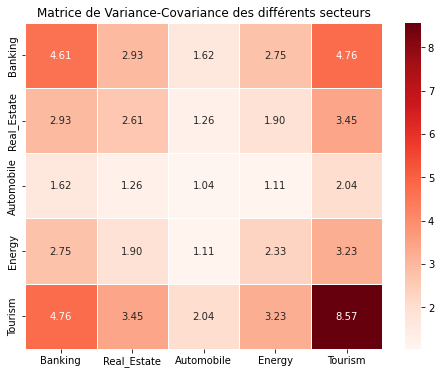

In [45]:
V = stats_dataframe(matrix_return(2020,2021), score('2020'))[1]

plt.figure(figsize=(8, 6))
sns.heatmap(V, annot=True, cmap='Reds', fmt=".2f", linewidths=.5)
plt.title("Matrice de Variance-Covariance des différents secteurs")
plt.show()

As expected, the matrix shows strong correlations between the different sectors for the years 2020 to 2021, for example.

## Calculation of the Markovitz allocation using the calculation seen in the course

In [46]:
def hmarkovitz(l, lambda0):
    """
    Calculates the Markowitz portfolio with constraints of sum equal to one and expected return equal to Alpha.

    Parameters:
    - l: list, [Alpha, V], where Alpha is the expected return and V is the covariance matrix of returns.
    - lambda0: float, parameter controlling the trade-off between return and risk.

    Returns:
    - numpy array, the calculated Markowitz portfolio.
    """
    Alpha = l[0]
    V = l[1]
    nrow = V.shape[0]
    V = np.array(V)
    V_inv = np.linalg.inv(V)

    A = np.ones((1, nrow), dtype=int)

    # Calculate the first term of the Markowitz portfolio
    r1 = np.concatenate(V_inv @ A.T @ (np.linalg.inv(A @ V_inv @ A.T)))

    # Calculate the second term of the Markowitz portfolio with the Lambda constraint
    r2 = lambda0 * V_inv @ (Alpha - A.T @ np.linalg.inv(A @ V_inv @ A.T) @ A @ V_inv @ Alpha)

    # Return the resulting Markowitz portfolio
    return r1 + r2


In [47]:
hmarkovitz(stats_dataframe(matrix_return(2015,2016), score('2015')),5)

[*********************100%***********************]  22 of 22 completed


array([ 0.04671987,  1.35401238,  0.45676517, -0.83814055, -0.01935688])

In [48]:
hmarkovitz(stats_dataframe(matrix_return(2015,2016), None),5)

[*********************100%***********************]  22 of 22 completed


array([ 0.28485581,  1.13412393,  0.1078828 , -0.55268079,  0.02581825])

We can see that there is a difference in allocation depending on whether the signal is used or not. The signal does distort the Markovitz algorithm.

In [49]:
def calendrier(start, end):
    """
    Generates a DataFrame with a 'dates' column containing monthly dates between start and end.

    Parameters:
    - start: int, start year.
    - end: int, end year.

    Returns:
    - DataFrame, containing a 'dates' column with monthly dates.
    """
    # Convert start year to date format
    start_date = pd.to_datetime(f'{start}-01-01')

    # Convert end year to date format and add a month to include the last complete year
    end_date = pd.to_datetime(f'{end-1}-12-31') + pd.DateOffset(months=1)

    # Generate a DataFrame with monthly dates between start_date and end_date
    df_dates = pd.DataFrame({
        'dates': pd.date_range(start=start_date, end=end_date, freq='MS')
    })

    return df_dates


In [51]:
def test_year(df):
    return int(len(df) / len(df.asfreq("Y"))) == 1

def sharpe_ratio(df, num_period_per_year=12):
    if test_year(df):
        num_period_per_year = 1
    if num_period_per_year is None:
        return np.nan
    else:
        return df.mean() / df.std() * np.sqrt(num_period_per_year)

def line(
    df,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    cumsum=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    legend_sharpe_ratio=None,
    legend=True,
    yscale=None,
    start_date=None,
):
    if loc == "best":
        bbox_to_anchor = None
    if isinstance(df, dict):
        df = pd.concat(df, axis=1)
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if start_date is not None:
        df = df[start_date:]
    if cumsum and (legend_sharpe_ratio is None):
        legend_sharpe_ratio = True
    if legend_sharpe_ratio:
        df.columns = [
            f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]
    if cumsum:
        df = df.cumsum()
    if sort:
        df = df.loc[:, lambda x: x.iloc[-1].sort_values(ascending=False).index]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(df.index.values, df.values)
    if legend:
        ax.legend(df.columns, loc=loc, bbox_to_anchor=bbox_to_anchor)
    ax.set_title(title)
    if yscale == "log":
        ax.set_yscale("log")

### Backtest function
This function is used to backtest our strategy with a signal and without a signal (benchmark).

In [54]:
def backtest(start, end, lambda0, signal=1):
    """
    Performs a backtest of a Markowitz portfolio over a given period.

    Parameters:
    - start: int, start year.
    - end: int, end year.
    - lambda0: float, parameter controlling the trade-off between return and risk.
    - signal: Here we choose 1 if we include the NLP signal and 0 otherwise, corresponding respectively to our strategy or the benchmark.

    Returns:
    - Series, the profit & loss (P&L) of the Markowitz portfolio over the period.
    """
    # Create a DataFrame with monthly dates between start+1 and end
    df = calendrier(start+1, end)

    # Initialize DataFrame columns for each sector
    df['Banking'] = 0
    df['Real_Estate'] = 0
    df['Automobile'] = 0
    df['Energy'] = 0
    df['Tourism'] = 0

    # Perform backtest for each year in the period
    for k in range(start, end):
        # Calculate the Markowitz portfolio for year k+1
        if signal == 1:
            M = hmarkovitz(stats_dataframe(matrix_return(k, k+1), score(str(k))), lambda0)
        if signal == 0:
            M = hmarkovitz(stats_dataframe(matrix_return(k, k+1), None), lambda0)

        # Update DataFrame columns for each sector with the weights of portfolio M
        for date in df['dates']:
            if date.year == (k+1):
                df.loc[df['dates'] == date, ['Banking', 'Real_Estate', 'Automobile', 'Energy', 'Tourism']] = M

    # Set dates as index of the DataFrame
    df.set_index('dates', inplace=True)

    # Calculate profit & loss (P&L) by multiplying returns by portfolio weights for each date
    pnl = df.mul(matrix_price_pnl(start+1, end, tick_list)).sum(axis=1)

    # Display the cumulative P&L curve of the Markowitz portfolio
    if signal == 0:
        line(pnl.rename('Markowitz Portfolio'), cumsum=True)
    if signal == 1:
        line(pnl.rename('Markowitz Portfolio with Signal'), cumsum=True)

    return pnl


## Presentation of results
For the different lambda coefficients we were able to observe (3rd parameter of the backtest function), our strategy has an advantage over the benchmark of around 10% of the sharpe ratio over 8 years. Here we present the two graphs for a risk aversion coefficient of 1.

[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed


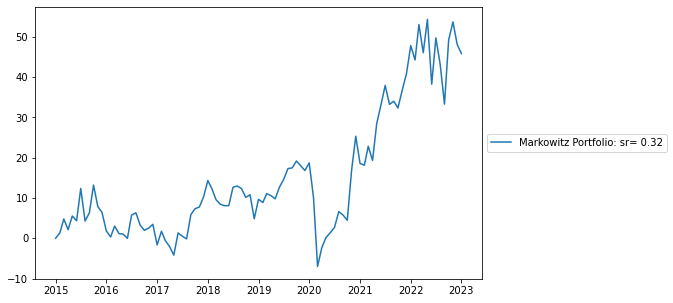

In [55]:
holds=backtest(2014,2023,5,0)

[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed


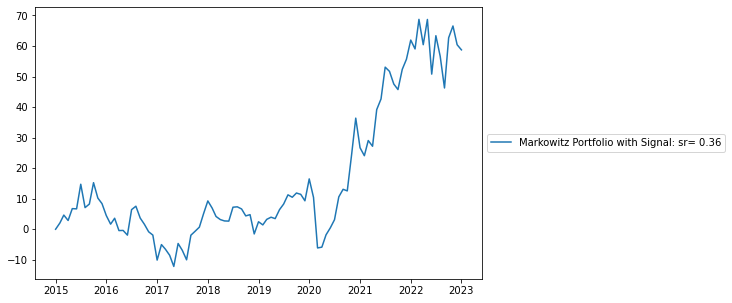

In [56]:
holds=backtest(2014,2023,5,1)